In [57]:
# --------------------
# Package import

import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.special as special
import scipy.interpolate as interpolate
import seaborn as sns

colors = sns.color_palette('bright')

#### global constants and units

c = 2.99792458e8 #m/s
G = 6.6743015e-11 # m^3 kg^-1 s^-2
H0 = 70.0 # km/s/Mpc
omega_L = 0.714
omega_m  = 0.286

Msun_to_kg = 1.988e30
yr_to_sec = 31556952.
Mpc_to_m = 3.086e22
Gpc_to_m = 3.086e25



#### mass parameters

beta = 1.40
mmin=4.59
delta=4.82
lambda_p = 0.10

#### BH mass distributions

In [151]:
#### Smoothing function

def smoothing(mm, mmin, delta):
    tmp = (1. + special.erf(mm-(mmin+delta/2.))) / 2.
    return tmp


#### Secondary mass distribution

def norm_massratio(m1):

    q = np.linspace(0.,1.,1001)
    step = np.diff(q)[:,np.newaxis]
    qq = np.tile(q,(m1.shape[0],1)).transpose()
    mm1 = np.tile(m1, (q.shape[0],1))

    SSP = qq**beta * smoothing(mm=qq*mm1, mmin=mmin, delta=delta)
    P = np.sum( (SSP[1:]+SSP[:-1]) * step/2. , axis=0)

    return P

mass1 = np.linspace(1.,101.,1001)
norm_massratio_pdf = interpolate.interp1d(mass1, norm_massratio(mass1), kind='cubic')

def massratio_pdf(q,m1):
    tmp = q**beta * smoothing(mm=q*m1, mmin=mmin, delta=delta) / norm_massratio_pdf(m1)
    #tmp = q**beta * smoothing(mm=q*m1, mmin=mmin, delta=delta) # Tessa's version, no normalization of the secondary
    return tmp


#### Primary mass distribution

def smoothed_gaussian(x):
    mu = 33.07
    sigma = 5.69
    return np.exp(-(x-mu)**2./2./sigma**2) * smoothing(mm=x, mmin=4.59, delta=4.82)

def smoothed_powerlaw(x):
    alpha = -2.63
    mmax = 86.22
    y = x**alpha * smoothing(mm=x, mmin=4.59, delta=4.82)
    y[x>mmax] = 0.
    return y

masses = np.linspace(1.,100., 10001)

GG = smoothed_gaussian(masses)
NSG = np.sum((GG[:-1]+GG[1:])*np.diff(masses)/2.)

PP = smoothed_powerlaw(masses)
NSP = np.sum((PP[:-1]+PP[1:])*np.diff(masses)/2.)

def primary_pdf(mm):

    G = smoothed_gaussian(mm) / NSG
    P = smoothed_powerlaw(mm) / NSP

    return (1-lambda_p) * P + lambda_p * G


#### BH orientations

In [161]:
#### binary orientation PDF

def theta_pdf(x):
    tmp = 5.*x/256. * (4.-x)**3.
    tmp[x>4.] = 0.
    return tmp

def theta_pdf_int(x):
    tmp = 1 - 5./8. * x**2. + 5./16. * x**3. - 15./256. * x**4. + x**5. / 256.
    tmp[x>4.] = 0.
    return tmp


#### integration over frequency

PSD = np.loadtxt('aLIGO_noise.txt')
freq = PSD[:,0]
S = PSD[:,1]**2.

def frequency_int(fmax):
    T = G/c**3. * Msun_to_kg
    I_int = 1./ T**(1./3.) / freq**(7./3.) / S

    f = np.tile(freq,(fmax.shape[0],1)).transpose()
    I_int = np.tile(I_int,(fmax.shape[0],1)).transpose()

    I_int[f>fmax] = 0.
    step = np.diff(freq)[:,np.newaxis]
    tmp = np.sum((I_int[1:,:]+I_int[:-1,:])*step/2., axis=0)
    return tmp

def maximum_frequency(m1,q,z):
    mtot = m1 * (1+q)
    tmp = 4397./(1.+z)/mtot
    return tmp

fmax = np.linspace(1.,10000.,1001)
frequency_integral = interpolate.interp1d(fmax, frequency_int(fmax), kind='cubic') # interpolate this integral, so we can keep the 2D dimensions in the n_gw integration

#### calculation of theta

def lumdist(z):
    z_int = np.linspace(0.,z,1001)
    H = H0 * np.sqrt((1+z_int)**3.*omega_m + omega_L) * 1.e3 # so the Dl is returned in Gpc
    dl_int = 1/H
    step = np.diff(z_int, axis=0)
    dl = np.sum((dl_int[1:] + dl_int[:-1])*step/2., axis=0)
    return c * 1.e-3 * (1+z) * dl

def Theta(m1,q,z,rho_th):
    Mc = m1 * q**(3./5.) / (1.+q)**(1./5.)
    fmax = maximum_frequency(m1, q, z)
    # fmax = 4397./2.**(5./6.)/(1+z)/Mc # Tessa's version, approximation on the f_max limit and maybe(?) error in the exponent at the denominator
    I = frequency_integral(fmax)

    dl = lumdist(z)
    R = G/c**2. * Msun_to_kg

    rho0 = np.sqrt(5./96./np.pi**(4./3.)) * R / dl / Gpc_to_m * ((1+z)*Mc)**(5./6.) * np.sqrt(I)
    return rho_th/rho0


#### BH number density

In [162]:
def gw_rate(z):
    r0 = 23.9
    tmp = r0 * (1.+z)**2.7 / (1. + ((1.+z)/2.9)**5.6)
    return tmp

def comoving_count(z, rho_th):

    # set up 3D arrays: first index corresponds to redshift, second index to primary mass and third index to mass ratio  - 
        # - this way, integrations always happen 'horizontally', i.e. along the highest dimensions -> no need to ever reshape when multiplying with 1D step arrays
    q = np.linspace(0.02,1.,100)
    m = np.linspace(3.,101.,101)

    qqq = np.tile(q[np.newaxis, np.newaxis, :], (z.shape[0], m.shape[0], 1))
    mmm = np.tile(m[np.newaxis, :, np.newaxis], (z.shape[0], 1, q.shape[0]))
    zzz = np.tile(z[:, np.newaxis, np.newaxis], (1, m.shape[0], q.shape[0]))

    # calculate integrand functions and free memory
    theta = Theta(mmm, qqq, zzz, rho_th)
    theta_int = theta_pdf_int(theta)
    theta = None
    massratio = massratio_pdf(qqq,mmm)
    #massratio = mmm * massratio_pdf(qqq,mmm) # Tessa's version, wrong conversion between (m1,q) -> (m1,Mc) spces
    primary = primary_pdf(mmm)
    qqq = None
    mmm = None
    zzz = None

    tmp3 = primary * massratio * theta_int

    theta_int = None
    massratio = None
    primary = None

    # integrate along mass ratio
    step_q = np.diff(q)
    tmp2 = np.sum( (tmp3[:,:,:-1] + tmp3[:,:,1:])*step_q/2. , axis=2)
    tmp3 = None

    # integrate along primary mass
    step_m = np.diff(m)
    tmp = np.sum( (tmp2[:,:-1] + tmp2[:,1:])*step_m/2. , axis=1)
    tmp2 = None

    # return n_gw as a function of redshift
    rate = gw_rate(z)/(1.+z)
    return tmp * rate

z = np.linspace(0.01, 1., 51)
count = comoving_count(z,8.)


    

Total number of events is:  94.0  each year


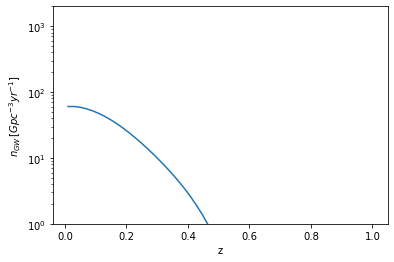

In [165]:
# Performs integration in comoving volume to compute the * total * number of GW events detected in a year. For LVK, this number should be about 300.

H = H0 * np.sqrt((1+z)**3.*omega_m + omega_L) * 1.e3 # so the Dl is returned in Gpc
I = count*4.*np.pi*lumdist(z)**2 / (1.+z)**2. * c * 1.e-3 / H 
print('Total number of events is: ', np.round(np.sum( (I[:-1]+I[1:]) * np.diff(z)/2.),0), ' each year')

plt.plot(z, 2.5*count)
plt.ylim(1.,2.e3)
plt.ylabel(r'$n_{GW} \,[Gpc^{-3} yr^{-1}]$')
plt.xlabel(r'z')
plt.yscale('log')
plt.show()
